In [ ]:
! nvidia-smi

Tue Aug 11 05:39:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from PIL import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [ ]:
from albumentations import (Compose, OneOf, 
                            CLAHE, Flip,Rotate,Transpose,ShiftScaleRotate,IAAPiecewiseAffine,RandomRotate90,ChannelShuffle,ElasticTransform,Flip,GridDistortion,HorizontalFlip,HueSaturationValue,OpticalDistortion,
                            RandomBrightnessContrast,RandomGamma,RandomSizedCrop,VerticalFlip,RGBShift,GaussNoise )

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import zipfile
local_zip = '/content/drive/My Drive/Dataset/Nuclei/Data.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close(
  
)
print("Done")

Done


In [ ]:
train_image_dir = r'/content/Data/images'
train_mask_dir = r'/content/Data/masks'

In [ ]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".png") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))

Number of training images :  670
Number of training masks :  670


In [ ]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)
train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [ ]:
print("After shuffling")
print(train_image_paths[0:5])
print(train_mask_paths[0:5])
# Sequence intact !

After shuffling
['/content/Data/images/110.png', '/content/Data/images/169.png', '/content/Data/images/84.png', '/content/Data/images/480.png', '/content/Data/images/328.png']
['/content/Data/masks/110.png', '/content/Data/masks/169.png', '/content/Data/masks/84.png', '/content/Data/masks/480.png', '/content/Data/masks/328.png']


In [ ]:
# Splitting
train_image_files = train_image_paths[:500]
train_mask_files = train_mask_paths[:500]

valid_image_files = train_image_paths[500:]
valid_mask_files = train_mask_paths[500:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


500 500
170 170


In [ ]:
def read_image(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.convert('RGB')
    img = img.resize(dim)
    img = np.array(img)
    return img

In [ ]:
def read_mask(file_loc, dim=(256,256)):
    img = Image.open(file_loc)
    img = img.resize(dim)
    img = np.array(img)
    img = (img>0).astype(np.uint8)
    return img

In [ ]:
class Train_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)
# Carefully selected augmentations...works fine with retina...idk abt nucleus !
  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0), 
      Rotate(always_apply = True,limit=(-360, 360), border_mode=3, p = 1.0),
      Flip(always_apply = True),
      OneOf([
             GaussNoise()
             ], p=0.9),
      OneOf([
             HorizontalFlip()
                 
      ], p=0.6),
      
      OneOf([
             
             RandomBrightnessContrast(),
             RandomGamma()
             ], p=0.2),
     OneOf([VerticalFlip()],p=0.7)
     ,
     OneOf([HueSaturationValue()],p=0.5)
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

In [ ]:
class Val_Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
       k=math.ceil(len(self.x) / self.batch_size)
      #  print(k)
      #  print(len(self.x))
      #  print(self.batch_size)
       return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0)
    ])


  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
      # print(batch_x)
      # print(batch_y)

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])
      batch_y = np.array([read_mask(file_name, self.img_dim) for file_name in batch_y])

      if self.augmentation is True:
        aug = [self.aug(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])
      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255.0, batch_y/1.0
  

In [ ]:
train_generator = Train_Generator(train_image_files, train_mask_files)
valid_generator = Val_Generator(valid_image_files, valid_mask_files)

In [ ]:
# Finally 3 dims 
for i, j in train_generator:
  print(i.dtype)
  print(j.dtype)
  break

float64
float64


In [ ]:
# Finally 3 dims 
for i, j in train_generator:
  print(i.shape)
  print(j.shape)
  break

(10, 256, 256, 3)
(10, 256, 256, 1)


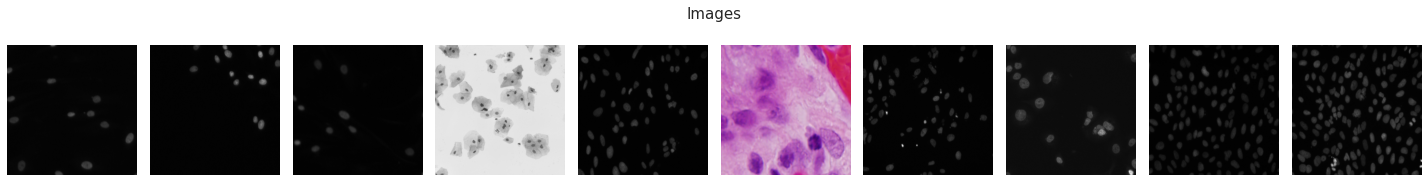

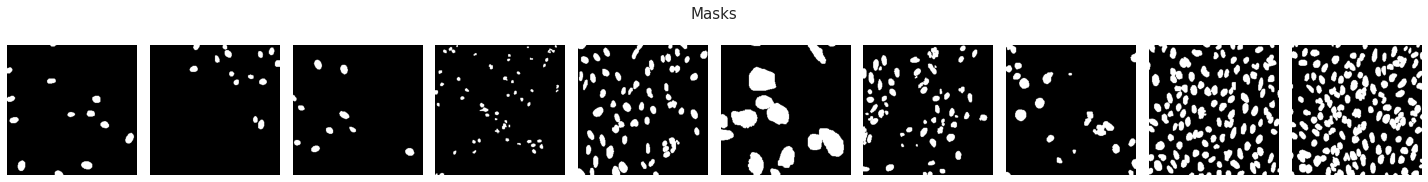

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def train_generator():
  return Train_Generator(train_image_files, train_mask_files, augmentation=True).__iter__()
def valid_generator():
  return Val_Generator(valid_image_files, valid_mask_files, augmentation=True).__iter__()


ds_train = tf.data.Dataset.from_generator(
    train_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,256,256,3], [None,256,256,1])
).repeat()

ds_valid = tf.data.Dataset.from_generator(
    valid_generator, 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([None,256,256,3], [None,256,256,1])
).repeat()


In [ ]:
 train_generator_aug = Train_Generator(train_image_files, train_mask_files,augmentation=True)

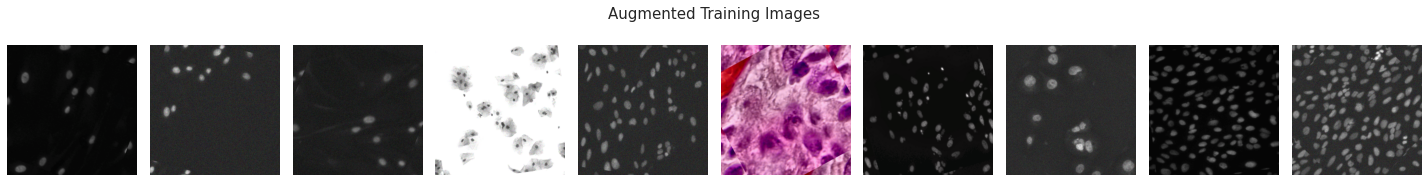

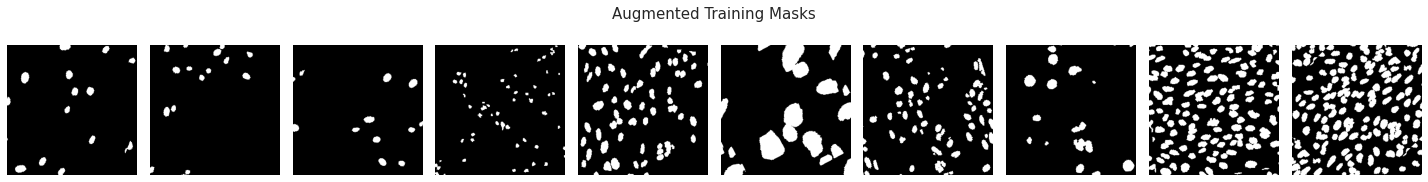

In [ ]:
# Augmented training set
for i, j in ds_train:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Augmented Training Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
 valid_generator_aug= Val_Generator(valid_image_files, valid_mask_files,augmentation=True)

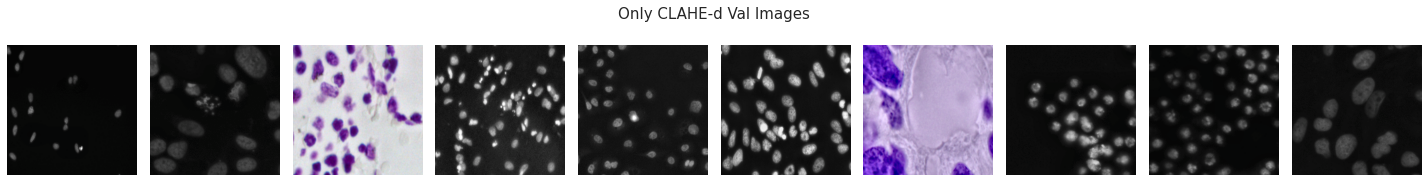

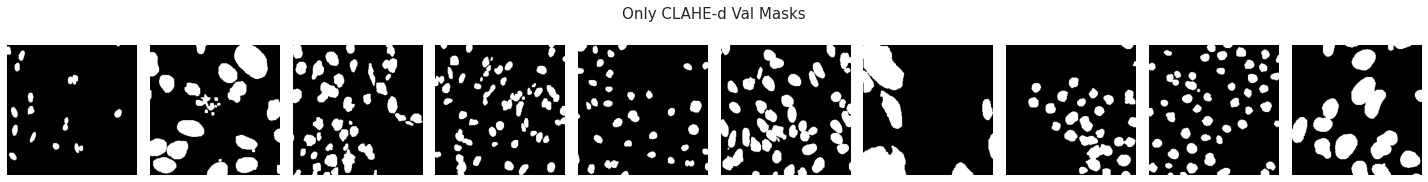

In [ ]:
# Augmented val set
for i, j in ds_valid:
    break

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Only CLAHE-d Val Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Only CLAHE-d Val Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = y_true * y_pred
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou(y_true, y_pred):
    thresh = 0.5
    smooth = 1.
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')
    intersection = K.sum(K.minimum(y_true, y_pred)) + smooth
    union = K.sum(K.maximum(y_true, y_pred)) + smooth
    iou = intersection/union
    return iou

In [ ]:
def nested_unet():

  inputs = Input((256,256, 3))

  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0') (inputs)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_conv_0 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_0_1') (A_conv_0)
  A_conv_0 = BatchNormalization() (A_conv_0)
  A_pool_0 = MaxPooling2D((2, 2)) (A_conv_0)

  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0') (A_pool_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_conv_0 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_0_1') (B_conv_0)
  B_conv_0 = BatchNormalization() (B_conv_0)
  B_pool_0 = MaxPooling2D((2, 2)) (B_conv_0)

  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0') (B_pool_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_conv_0 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_0_1') (C_conv_0)
  C_conv_0 = BatchNormalization() (C_conv_0)
  C_pool_0 = MaxPooling2D((2, 2)) (C_conv_0)

  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0') (C_pool_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_conv_0 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_0_1') (D_conv_0)
  D_conv_0 = BatchNormalization() (D_conv_0)
  D_pool_0 = MaxPooling2D((2, 2)) (D_conv_0)

  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0') (D_pool_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_conv_0 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='E_conv_0_1') (E_conv_0)
  E_conv_0 = BatchNormalization() (E_conv_0)
  E_pool_0 = MaxPooling2D((2, 2)) (E_conv_0)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_1') (B_conv_0)
  A_conv_1 = concatenate([A_conv_0, A_conv_1], name='A_concat_1')
  A_conv_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_1') (A_conv_1)
  A_conv_1 = BatchNormalization() (A_conv_1)

  B_conv_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_1') (C_conv_0)
  B_conv_1 = concatenate([B_conv_0, B_conv_1], name='B_concat_1')
  B_conv_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_1') (B_conv_1)
  B_conv_1 = BatchNormalization() (B_conv_1)

  C_conv_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_1') (D_conv_0)
  C_conv_1 = concatenate([C_conv_0, C_conv_1], name='C_concat_1')
  C_conv_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_1') (C_conv_1)
  C_conv_1 = BatchNormalization() (C_conv_1)

  D_conv_1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='D_trans_1') (E_conv_0)
  D_conv_1 = concatenate([D_conv_0, D_conv_1], name='D_concat_1')
  D_conv_1 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='D_conv_1') (D_conv_1)
  D_conv_1 = BatchNormalization() (D_conv_1)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_2') (B_conv_1)
  A_conv_2 = concatenate([A_conv_0, A_conv_1, A_conv_2], name='A_concat_2')
  A_conv_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_2') (A_conv_2)
  A_conv_2 = BatchNormalization() (A_conv_2)

  B_conv_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_2') (C_conv_1)
  B_conv_2 = concatenate([B_conv_0, B_conv_1, B_conv_2], name='B_concat_2')
  B_conv_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_2') (B_conv_2)
  B_conv_2 = BatchNormalization() (B_conv_2)

  C_conv_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='C_trans_2') (D_conv_1)
  C_conv_2 = concatenate([C_conv_0, C_conv_1, C_conv_2], name='C_concat_2')
  C_conv_2 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='C_conv_2') (C_conv_2)
  C_conv_2 = BatchNormalization() (C_conv_2)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_3') (B_conv_2)
  A_conv_3 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3], name='A_concat_3')
  A_conv_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_3') (A_conv_3)
  A_conv_3 = BatchNormalization() (A_conv_3)

  B_conv_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='B_trans_3') (C_conv_2)
  B_conv_3 = concatenate([B_conv_0, B_conv_1, B_conv_2, B_conv_3], name='B_concat_3')
  B_conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='B_conv_3') (B_conv_3)
  B_conv_3 = BatchNormalization() (B_conv_3)

  #-------------------------------------------------------------------------------------------------------------#

  A_conv_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='A_trans_4') (B_conv_3)
  A_conv_4 = concatenate([A_conv_0, A_conv_1, A_conv_2, A_conv_3, A_conv_4], name='A_concat_4')
  A_conv_4 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', name='A_conv_4') (A_conv_4)
  A_conv_4 = BatchNormalization() (A_conv_4)

  #-------------------------------------------------------------------------------------------------------------#

  A_out_1 = Conv2D(1, (1, 1), activation='sigmoid',name='out1') (A_conv_1)
  A_out_2 = Conv2D(1, (1, 1), activation='sigmoid',name='out2') (A_conv_2)
  A_out_3 = Conv2D(1, (1, 1), activation='sigmoid',name='out3') (A_conv_3)
  A_out_4 = Conv2D(1, (1, 1), activation='sigmoid',name='out4') (A_conv_4)

  outputs = average([A_out_1, A_out_2, A_out_3, A_out_4])

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

model = nested_unet()
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
A_conv_0 (Conv2D)               (None, 256, 256, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_140 (BatchN (None, 256, 256, 64) 256         A_conv_0[0][0]                   
__________________________________________________________________________________________________
A_conv_0_1 (Conv2D)             (None, 256, 256, 64) 36928       batch_normalization_140[0][0]    
______________________________________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
def lr_schedule(epoch):

    lr =0.001
    if epoch >15:
        lr *=2**-1
    elif epoch >10:
        lr *=2**(-1)
    elif epoch >8:
        lr *=2**(-1)
    elif epoch >5:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [ ]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]


In [ ]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
# optimiser=tf.keras.optimizers.SGD(
#     learning_rate=lr_schedule(0),

# )
model.compile(optimizer =optimiser , loss = bce_dice_loss, metrics = ['accuracy', iou,'AUC'])

Learning rate:  0.001


In [ ]:

history = model.fit(
    ds_train, 
    steps_per_epoch=500//10,
    epochs=20,
    validation_data = ds_valid,    
    validation_steps =170//10,callbacks=callbacks
     )

Learning rate:  0.001
Epoch 1/20
50/50 [==============================] - 46s 914ms/step - loss: 0.7597 - accuracy: 0.8800 - iou: 0.5518 - auc: 0.9456 - val_loss: 1.1039 - val_accuracy: 0.8405 - val_iou: 0.2621 - val_auc: 0.7742
Learning rate:  0.001
Epoch 2/20
50/50 [==============================] - 45s 899ms/step - loss: 0.5328 - accuracy: 0.9387 - iou: 0.6766 - auc: 0.9657 - val_loss: 1.2504 - val_accuracy: 0.5223 - val_iou: 0.2098 - val_auc: 0.8103
Learning rate:  0.001
Epoch 3/20
50/50 [==============================] - 45s 903ms/step - loss: 0.4007 - accuracy: 0.9523 - iou: 0.7284 - auc: 0.9713 - val_loss: 1.6471 - val_accuracy: 0.3815 - val_iou: 0.2003 - val_auc: 0.7703
Learning rate:  0.001
Epoch 4/20
50/50 [==============================] - 45s 903ms/step - loss: 0.3400 - accuracy: 0.9567 - iou: 0.7477 - auc: 0.9758 - val_loss: 0.5440 - val_accuracy: 0.9290 - val_iou: 0.6128 - val_auc: 0.9558
Learning rate:  0.001
Epoch 5/20
50/50 [==============================] - 45s 902ms/

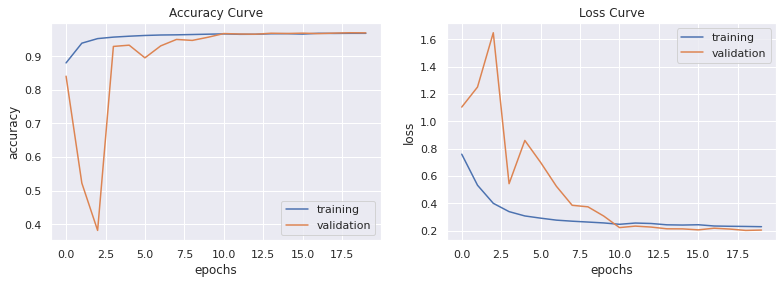

In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

test_generator = Val_Generator(valid_image_files, valid_mask_files, 100)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

y_true = (y_test>0.5).flatten()
y_pred = (y_pred>0.5).flatten()

# U-NET basic
report = classification_report(y_true, y_pred, output_dict=True)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)
AUC = roc_auc_score(y_true.flatten(), y_pred.flatten())

print("Precision score: {0:.2f}\n".format(Precision))
print("Recall score: {0:.2f}\n".format(Recall))
print("F1-Score: {0:.2f}\n".format(F1_score))
print("Sensitivity: {0:.2f}\n".format(Sensitivity))
print("Specificity: {0:.2f}\n".format(Specificity))
print("IOU: {0:.2f}\n".format(IOU))
print("AUC: {0:.2f}\n".format(AUC))
print('-'*50,'\n')
print(classification_report(y_true, y_pred))

Precision score: 0.91

Recall score: 0.87

F1-Score: 0.89

Sensitivity: 0.87

Specificity: 0.98

IOU: 0.81

AUC: 0.93

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.97      0.98      0.98   5447804
        True       0.91      0.87      0.89   1105796

    accuracy                           0.96   6553600
   macro avg       0.94      0.93      0.94   6553600
weighted avg       0.96      0.96      0.96   6553600



In [ ]:
valid_generator = Val_Generator(valid_image_files, valid_mask_files, 1)

x_val = []
y_val = []
p_val = []

for x, y in valid_generator:
  p = model.predict(x)
  x_val.append(np.squeeze(x, 0))
  y_val.append(np.squeeze(y, 0))
  p_val.append(np.squeeze(p, 0))

x_val = np.array(x_val) # Image
y_val = np.array(y_val) # Mask
p_val = np.array(p_val) # Predicted mask

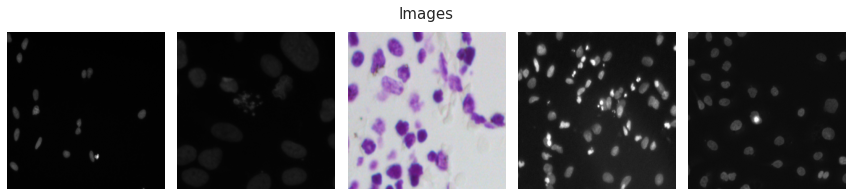

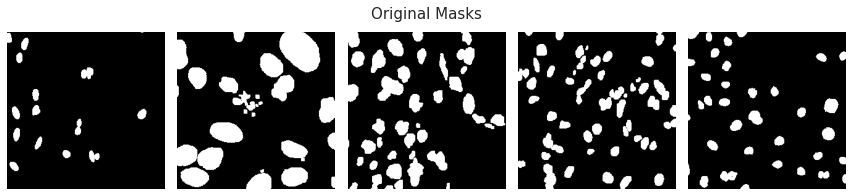

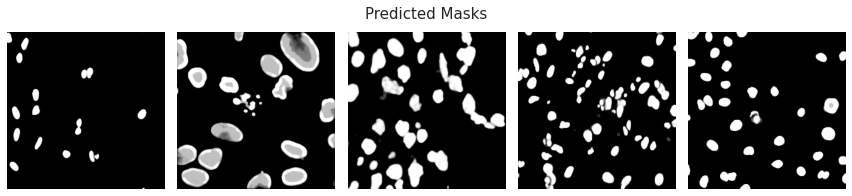

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(x_val[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(y_val[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Predicted Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
 test_image_files = [os.path.join('/content/Data/test', i) for i in os.listdir('/content/Data/test')]

In [ ]:
class Test_Generator(Sequence):

  def __init__(self, x_set, batch_size=10, img_dim=(256,256), augmentation=False):
      self.x = x_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augmentation = augmentation

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  aug = Compose(
    [
      CLAHE(always_apply=True, p=1.0)
    ])


  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

      # batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_x])
      # batch_y = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (512, 512)) for file_name in batch_y])
      batch_x = np.array([read_image(file_name, self.img_dim) for file_name in batch_x])

      if self.augmentation is True:
        aug = [self.aug(image=i) for i in batch_x]
        batch_x = np.array([i['image'] for i in aug])

      return batch_x/255.0

In [ ]:
test_generator = Test_Generator(test_image_files, 1)

x_test = []
p_test = []

for x in test_generator:
  p = model.predict(x)
  x_test.append(np.squeeze(x, 0))
  p_test.append(np.squeeze(p, 0))

x_test = np.array(x_test) # Image
p_test = np.array(p_test) # Predicted mask

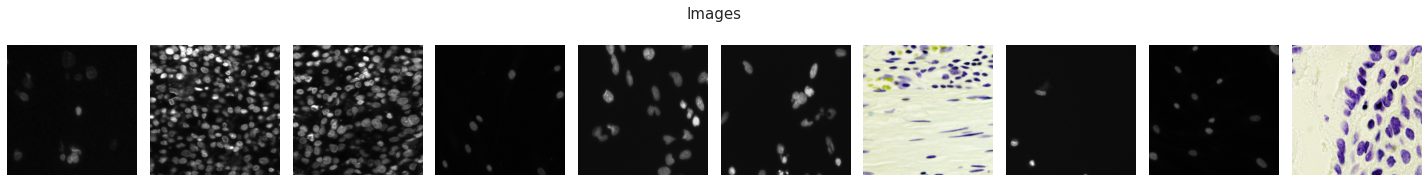

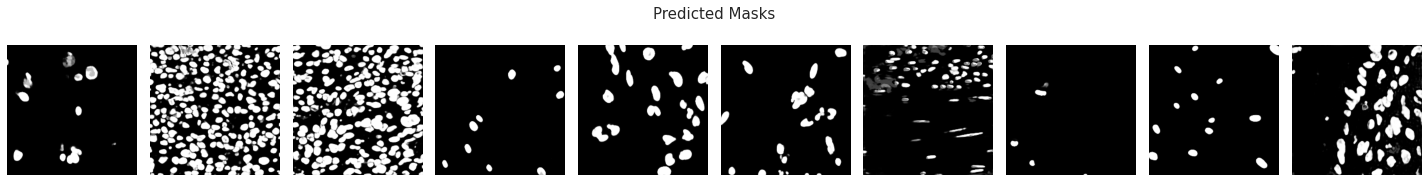

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(x_test[:10], axes[:10]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 10, figsize=(20,3))
fig.suptitle('Predicted Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_test[:10], axes[:10]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()